In [1]:
%load_ext cython

In [2]:
import numpy as np

def load_profits_from_file(filename, num_objectives, num_items):
    profits = np.zeros((num_objectives, num_items), dtype=int)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            idx += 1  # skip weight
            profit = int(lines[idx])
            profits[obj, item] = profit
            idx += 1
    return profits

def load_weights_from_file(filename, num_objectives, num_items):
    weights = np.zeros((num_objectives, num_items), dtype=int)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            weight = int(lines[idx])
            weights[obj, item] = weight
            idx += 2  # skip profit
    return weights

def load_capacities_from_file(filename, num_objectives, num_items):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    capacities = []
    for obj in range(num_objectives):
        cap = float(lines[idx])
        capacities.append(cap)
        idx += 1 + 3 * num_items
    return np.array(capacities)

In [3]:
import numpy as np
import requests
import re
from typing import Tuple, Dict, Any, Optional

class IntelligentAgentWithLLM:
    def __init__(
        self,
        num_items: int,
        num_objectives: int,
        profits: Optional[np.ndarray] = None,
        weights: Optional[np.ndarray] = None,
        capacities: Optional[np.ndarray] = None,
        attempts_per_move: int = 1,
        smoothing: float = 0.1,
        llm_endpoint: str = "http://localhost:11434/api/generate",
        gses_interval: int = 10,
    ):
        self.num_items = num_items
        self.num_objectives = num_objectives
        self.profits = profits
        self.weights = weights
        self.capacities = capacities
        self.attempts_per_move = attempts_per_move
        self.smoothing = smoothing
        self.llm_endpoint = llm_endpoint
        self.gses_interval = gses_interval
        self.generation = 0

        self.move_types = ["local_search", "global_search", "follow", "mutation", "diversity"]
        self.move_funcs = {
            "local_search": self.local_search_move,
            "global_search": self.global_search_move,
            "follow": self.follow_move,
            "mutation": self.mutation_move,
            "diversity": self.diversity_move
        }
        self.llm_moves = []
        self.llm_code_history = []
        self.move_counts = {k: 1 for k in self.move_types}
        self.move_successes = {k: 1 for k in self.move_types}
        self.move_probs = np.array([0.25, 0.20, 0.15, 0.15, 0.25], dtype=np.float64)
        self.best_observation = None
        self.last_move_type = None
        self.last_feedback = None

    def observe(self, state: Dict[str, Any]) -> np.ndarray:
        return np.array(state["Items"], dtype=np.int32)

    def act(self, observation: np.ndarray, context: Dict[str, Any] = None) -> Tuple[int, int]:
        archive_objs = None
        if context is not None and "archive_objs" in context:
            archive_objs = context["archive_objs"]

        move_idx = np.random.choice(len(self.move_types), p=self.move_probs)
        move_type = self.move_types[move_idx]
        self.last_move_type = move_type

        move_func = self.move_funcs[move_type]
        for _ in range(self.attempts_per_move):
            move = move_func(observation, archive_objs)
            if self._is_feasible(observation, move):
                return move

        # Fallback to feasible random mutation
        for _ in range(self.attempts_per_move * 2):
            move = self.mutation_move(observation)
            if self._is_feasible(observation, move):
                return move

        return (0, 0)

    def report_move_result(self, move_type: Optional[str], success: bool):
        if move_type is None:
            move_type = self.last_move_type
        if move_type not in self.move_types:
            return
        self.move_counts[move_type] += 1
        if success:
            self.move_successes[move_type] += 1
        rates = np.array([self.move_successes[k] / self.move_counts[k] for k in self.move_types], dtype=np.float64)
        exp_rates = np.exp(rates / self.smoothing)
        new_probs = exp_rates / np.sum(exp_rates)
        self.move_probs = 0.5 * self.move_probs + 0.5 * new_probs
        self.move_probs = self.move_probs / np.sum(self.move_probs)

    def update_best(self, observation: np.ndarray):
        self.best_observation = observation.copy()

    # --- LLM Reflection every gses_interval ---
    def gses_reflect(self, archive_objs, agent_stats=None):
        self.generation += 1
        if self.generation % self.gses_interval != 0:
            return
        previous_code = self.llm_code_history[-1] if self.llm_code_history else None
        feedback = self.last_feedback
        code = self.prompt_llm_for_move_func(archive_objs, agent_stats, previous_code, feedback)
        if code:
            new_func = self._validate_and_integrate_llm_func(code, archive_objs)
            if new_func:
                move_name = f"llm_move_{len(self.llm_moves)}"
                self.move_types.append(move_name)
                self.move_funcs[move_name] = new_func
                self.move_probs = np.ones(len(self.move_types)) / len(self.move_types)
                self.llm_moves.append(new_func)
                self.llm_code_history.append(code)
                self.last_feedback = "LLM move integrated successfully."
                print(f"LLM move {move_name} integrated.")

    def prompt_llm_for_move_func(self, archive_objs, agent_stats, previous_code=None, feedback=None):
        improved_example = '''
def llm_move(observation, profits, weights, capacities, archive_objs):
    import numpy as np
    observation = np.array(observation, dtype=int)
    profits = np.array(profits)
    weights = np.array(weights)
    capacities = np.array(capacities)
    archive_objs = np.array(archive_objs)
    items_selected = [i for i, x in enumerate(observation) if x == 1]
    items_unselected = [i for i, x in enumerate(observation) if x == 0]
    best_hv_gain = float('-inf')
    best_move = (-1, -1)
    ref_point = np.max(archive_objs, axis=0) + 100 if len(archive_objs) > 0 else np.max(profits, axis=1) + 100
    def fast_hv(points, ref_point):
        points = np.array(points)
        points = points[points[:,0].argsort()]
        hv = 0.0
        prev_y = ref_point[1]
        for x, y in points:
            hv += abs(prev_y - y) * abs(ref_point[0] - x)
            prev_y = y
        return hv
    for remove_idx in items_selected:
        for add_idx in items_unselected:
            candidate = observation.copy()
            candidate[remove_idx] = 0
            candidate[add_idx] = 1
            total_weights = np.sum(weights * candidate, axis=1)
            if np.all(total_weights <= capacities):
                candidate_objs = np.sum(profits * candidate, axis=1)
                dominated = False
                for point in archive_objs:
                    if np.all(point >= candidate_objs) and np.any(point > candidate_objs):
                        dominated = True
                        break
                if not dominated:
                    new_archive = np.vstack([archive_objs, candidate_objs])
                    hv_gain = fast_hv(new_archive, ref_point) - fast_hv(archive_objs, ref_point)
                    if hv_gain > best_hv_gain:
                        best_hv_gain = hv_gain
                        best_move = (remove_idx, add_idx)
    return best_move
'''
        prompt = (
            "You are a metaheuristic designer for multi-objective knapsack optimization.\n"
            "Write ONLY the Python code for a move function that, given a current solution, proposes a single-item swap (remove one, add one) move.\n"
            "Strict requirements:\n"
            "- Moves must be feasible.\n"
            "- Moves must be non-dominated with respect to archive_objs.\n"
            "- Prefer moves that increase the hypervolume (HV) of the archive.\n"
            "- Never modify the archive; only use it for comparison.\n"
            "- Do NOT use any external libraries except numpy; use the provided fast HV code for hypervolume.\n"
            "- Always end with 'return best_move'.\n"
            "Here is an improved example to follow:\n"
            f"{improved_example}\n"
        )
        if previous_code:
            prompt += "\nPrevious move function code:\n" + previous_code + "\n"
        if feedback:
            prompt += f"\nFeedback on previous moves:\n{feedback}\n"
        prompt += "\nReturn ONLY the function definition above, with no explanation, markdown, or extra text."
        try:
            response = requests.post(
                self.llm_endpoint,
                json={
                    "model": "llama3",
                    "prompt": prompt,
                    "stream": False
                }
            )
            text = response.json()["response"]
            text = text.replace("```python", "").replace("```", "").strip()
            code_match = re.search(
                r"def llm_move\([^\)]*\):(?:\n|.)*?return best_move", text
            )
            if code_match:
                code = code_match.group(0)
                return code
        except Exception as e:
            print("LLM error:", e)
        return None

    def _validate_and_integrate_llm_func(self, code, archive_objs):
        loc = {}
        try:
            exec(code, {"np": np}, loc)
            llm_func = [v for v in loc.values() if callable(v)][0]
            for _ in range(10):
                obs = np.random.randint(0, 2, size=self.num_items)
                move = llm_func(obs, self.profits, self.weights, self.capacities, archive_objs)
                if not self._is_feasible(obs, move):
                    return None
            return llm_func
        except Exception as e:
            print("LLM func integration failed:", e)
            return None

    # --- Heuristic Moves ---
    def local_search_move(self, observation, archive_objs=None):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or self.profits is None:
            return 0, 0
        profs_selected = np.sum(self.profits[:, items_selected], axis=0)
        profs_unselected = np.sum(self.profits[:, items_unselected], axis=0)
        remove_idx = items_selected[np.argmin(profs_selected)]
        add_idx = items_unselected[np.argmax(profs_unselected)]
        return int(remove_idx), int(add_idx)

    def global_search_move(self, observation, archive_objs=None):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or self.profits is None:
            return 0, 0
        profs_selected = np.sum(self.profits[:, items_selected], axis=0)
        profs_unselected = np.sum(self.profits[:, items_unselected], axis=0)
        ps = profs_selected + 1e-9
        pu = profs_unselected + 1e-9
        remove_idx = np.random.choice(items_selected, p=ps / np.sum(ps))
        add_idx = np.random.choice(items_unselected, p=pu / np.sum(pu))
        return int(remove_idx), int(add_idx)

    def follow_move(self, observation, archive_objs=None):
        if self.best_observation is None:
            return self.mutation_move(observation)
        diff = self.best_observation - observation
        add_candidates = np.where((diff == 1) & (observation == 0))[0]
        remove_candidates = np.where((diff == -1) & (observation == 1))[0]
        if len(add_candidates) == 0 or len(remove_candidates) == 0:
            return self.mutation_move(observation)
        add_idx = np.random.choice(add_candidates)
        remove_idx = np.random.choice(remove_candidates)
        return int(remove_idx), int(add_idx)

    def mutation_move(self, observation, archive_objs=None):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0:
            return 0, 0
        remove_idx = int(np.random.choice(items_selected))
        add_idx = int(np.random.choice(items_unselected))
        return remove_idx, add_idx

    def diversity_move(self, observation, archive_objs):
        best_move = None
        best_min_dist = -np.inf
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or archive_objs is None or archive_objs.shape[0] == 0:
            return 0, 0
        for _ in range(self.attempts_per_move):
            remove_idx = int(np.random.choice(items_selected))
            add_idx = int(np.random.choice(items_unselected))
            if not self._is_feasible(observation, (remove_idx, add_idx)):
                continue
            candidate = observation.copy()
            candidate[remove_idx] = 0
            candidate[add_idx] = 1
            candidate_objs = np.sum(self.profits * candidate, axis=1)
            dists = np.linalg.norm(archive_objs - candidate_objs, axis=1)
            min_dist = np.min(dists)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_move = (remove_idx, add_idx)
        return best_move if best_move is not None else (0, 0)

    # --- Feasibility Checking ---
    def _is_feasible(self, observation, move):
        if self.weights is None or self.capacities is None or move is None:
            return True
        remove_idx, add_idx = move
        if remove_idx == add_idx:
            return False
        items = observation.copy()
        if items[remove_idx] == 0 or items[add_idx] == 1:
            return False
        items[remove_idx] = 0
        items[add_idx] = 1
        total_weights = np.sum(self.weights * items, axis=1)
        feasible = np.all(total_weights <= self.capacities)
        return feasible

In [4]:
%%cython
import numpy as np
cimport numpy as np
from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset

cdef int ni = 250           # Number of items (change as needed)
cdef int nf = 2             # Number of objectives (change as needed)
cdef int L = 5
cdef int alpha = 10
cdef int paretoIni = 28000

cdef double *capacities = NULL      # [nf]
cdef int **weights = NULL           # [nf][ni]
cdef int **profits = NULL           # [nf][ni]

cdef public object py_agent = None
cdef public object move_stats = None

def set_agent(agent):
    global py_agent
    py_agent = agent

def reset_move_stats():
    global move_stats
    move_stats = {"total_agent_calls": 0, "move_type_counts": {}, "total_time_agent": 0.0, "total_time_loop": 0.0}

def print_move_stats():
    print("\n=== AGENT MOVE PROFILE ===")
    print("Total agent calls:", move_stats["total_agent_calls"])
    print("Move type counts:", move_stats["move_type_counts"])
    print("Total agent time (sec):", move_stats["total_time_agent"])
    print("Total loop time (sec):", move_stats["total_time_loop"])

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef void extractPtoArchive(pop *P, pop *archive):
    cdef int i
    for i in range(P.size):
        if archive.size < archive.maxsize:
            archive.ind_array[archive.size] = ind_copy(P.ind_array[i])
            archive.size += 1

# --- Initialization & Evaluation using REAL profits/weights ---
cdef void evaluate(ind *x):
    cdef int j, l, k, feasible
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        feasible = 1
        for l in range(nf):
            if x.capa[l] + weights[l][j] > capacities[l]:
                feasible = 0
        if x.Items[j] and feasible:
            for k in range(nf):
                x.capa[k] += weights[k][j]
                x.f[k] += profits[k][j]
            x.nombr += 1
        else:
            x.Items[j] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    import random
    cdef int i, j
    SP.size = alpha
    for i in range(alpha):
        SP.ind_array[i] = create_ind(nf)
        for j in range(ni):
            SP.ind_array[i].Items[j] = random.randint(0, 1)
        evaluate(SP.ind_array[i])

# Dummy functions for completeness (replace with your real logic if needed)
cdef void loadMOKP(char *filename): pass
cdef void read_weights_file(char *filename): pass
cdef void choose_weight(): pass
cdef void calcul_weight(pop *SP, int size): pass
cdef double calcMaxbound(pop *SP, int size): return 1.0
cdef void compute_all_fitness(pop *SP): pass

cdef np.ndarray get_items(ind *x):
    arr = np.zeros(ni, dtype=np.int32)
    for i in range(ni):
        arr[i] = x.Items[i]
    return arr

import time
cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef int i, j, l, r, IM, taille, remove_idx, add_idx, tv, sol, mino, maxp, item_to_add, consistant, feasible
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    cdef np.ndarray[np.int32_t, ndim=1] items_mv = np.empty(ni, dtype=np.int32)
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    while True:
        loop_start_time = time.time()
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    for r in range(ni):
                        items_mv[r] = x.Items[r]
                    # Simple random move type for demo (replace with your logic)
                    sel = [ii for ii in range(ni) if x.Items[ii] == 1]
                    unsel = [ii for ii in range(ni) if x.Items[ii] == 0]
                    if sel and unsel:
                        remove_idx = sel[irand(len(sel))]
                        add_idx = unsel[irand(len(unsel))]
                    else:
                        remove_idx = 0
                        add_idx = 0
                    # Remove item (real profits/weights)
                    x.Items[remove_idx] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][remove_idx]
                        x.f[r] -= profits[r][remove_idx]
                    IM = 0
                    taille = 0
                    while IM < L:
                        item_to_add = add_idx
                        if item_to_add < 0 or item_to_add >= ni or x.Items[item_to_add] != 0 or item_to_add == remove_idx:
                            while True:
                                item_to_add = irand(ni)
                                if x.Items[item_to_add] == 0 and item_to_add != remove_idx:
                                    break
                        consistant = 1
                        r = 0
                        while r < nf and consistant == 1:
                            if x.capa[r] + weights[r][item_to_add] > capacities[r]:
                                consistant = 0
                            r += 1
                        if consistant == 1:
                            feasible = 1
                            r = 0
                            while r < taille and feasible:
                                if item_to_add == remplace[r]:
                                    feasible = 0
                                r += 1
                            if feasible == 1:
                                remplace[taille] = item_to_add
                                taille += 1
                                x.Items[item_to_add] = 1
                                x.nombr_nonpris -= 1
                                x.nombr += 1
                                for r in range(nf):
                                    x.capa[r] += weights[r][item_to_add]
                                    x.f[r] += profits[r][item_to_add]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * 1.0
                    j += 1
                free_ind(x)
                if j == x.nombr:
                    SP.ind_array[i].explored = 1
        loop_end_time = time.time()
        if move_stats is not None:
            move_stats["total_time_loop"] += (loop_end_time - loop_start_time)
        break
    free(remplace)

def run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file):
    global nf, ni, alpha, paretoIni
    alpha = 10
    paretoIni = 28000
    NBL = 25
    NRUNS = 3

    reset_move_stats()    # Only once, before runs

    for run in range(1, NRUNS+1):
        ni = nbitems
        nf = num_objectives

        print(f"RUN {run}/{NRUNS} -- {instance_file} nbitems={ni} nf={nf} => {output_file}")

        seed(run)
        loadMOKP(instance_file)
        read_weights_file(weights_file)

        P = create_pop(paretoIni, nf)

        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)
            Indicator_local_search1(solutions, archive, alpha)
            extractPtoArchive(archive, P)
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)

        with open(output_file, "w") as fpareto:
            fpareto.write("\n")
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")

        complete_free_pop(P)
        print_move_stats()    # Only once per run, after each run

Content of stdout:
_cython_magic_aee284767cb97729fc679b6952640ea6bf69cb3899de997c13471db1622a935d.c
A:\conda\envs\ibmols\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_aee284767cb97729fc679b6952640ea6bf69cb3899de997c13471db1622a935d.c(7056): warning C4244: 'fonction'ÿ: conversion de 'Py_ssize_t' en 'int', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_aee284767cb97729fc679b6952640ea6bf69cb3899de997c13471db1622a935d.c(7071): warning C4244: 'fonction'ÿ: conversion de 'Py_ssize_t' en 'int', perte possible de donn‚es
   Cr‚ation de la bibliothŠque C:\Users\Aziz il patal\.ipython\cython\Users\Aziz il patal\.ipython\cython\_cython_magic_aee284767cb97729fc679b6952640ea6bf69cb3899de997c13471db1622a935d.cp39-win_amd64.lib et de l'objet C:\Users\Aziz il patal\.ipython\cython\Users

In [5]:

def register_cython_moves(agent, profits):
    agent.register_move("mutation", lambda obs: cy_mutation_move(obs))
    agent.register_move("local_search", lambda obs: cy_local_search_move(obs, profits))
    agent.register_move("global_search", lambda obs: cy_global_search_move(obs, profits))

In [ ]:
# Parameters
nbitems = 250
num_objectives = 2
instance_file = "250.2.txt"
weights_file = "Weights_2obj_FQ200.txt"
output_file = "bro9.txt"
random_seed = 42

# Load data
profits = load_profits_from_file(instance_file, num_objectives, nbitems)
weights = load_weights_from_file(instance_file, num_objectives, nbitems)
capacities = load_capacities_from_file(instance_file, num_objectives, nbitems)

# Create agent
agent = ModularAgent(
    num_items=nbitems,
    num_objectives=num_objectives,
    profits=profits,
    weights=weights,
    capacities=capacities,
    random_seed=random_seed,
    profile=True
)

# Optionally: Register fast Cython moves if available
# register_cython_moves(agent, profits)

# Register agent with Cython core
set_agent(agent)

# Run the optimizer
run_moacp(instance_file.encode(), weights_file.encode(), nbitems, num_objectives, output_file)
print("Optimization completed.")

# Agent profiling summary
agent.print_profile()

In [ ]:
print("Reference Pareto min/max:", ref_pareto.min(axis=0), ref_pareto.max(axis=0))
print("Improved Pareto min/max:", new_pareto.min(axis=0), new_pareto.max(axis=0))

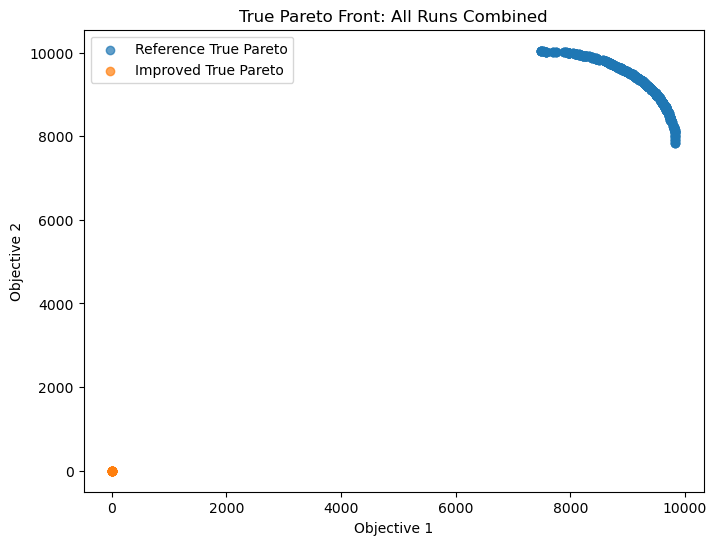

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("bro9.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

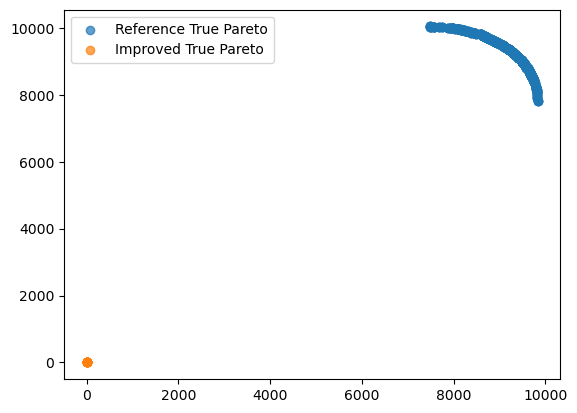

In [34]:
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.legend()
plt.show()

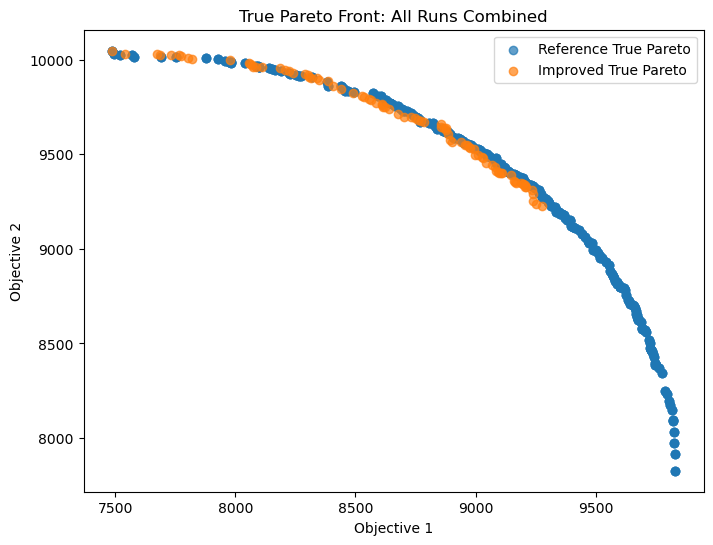

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("bro8.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

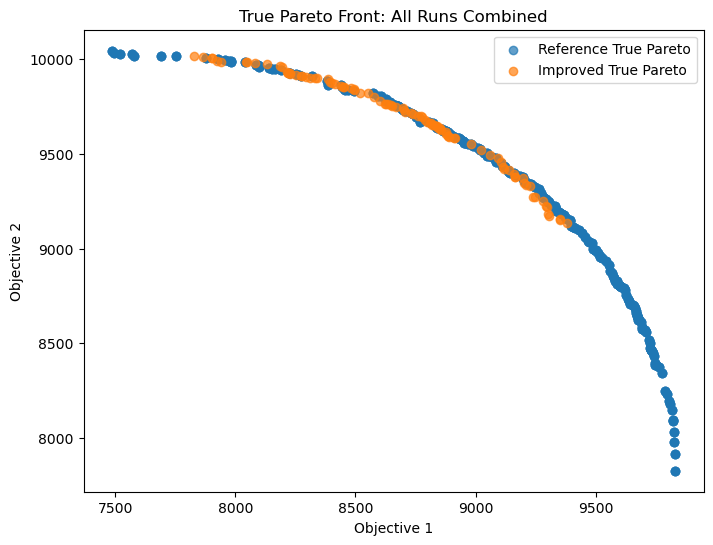

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("bro3.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

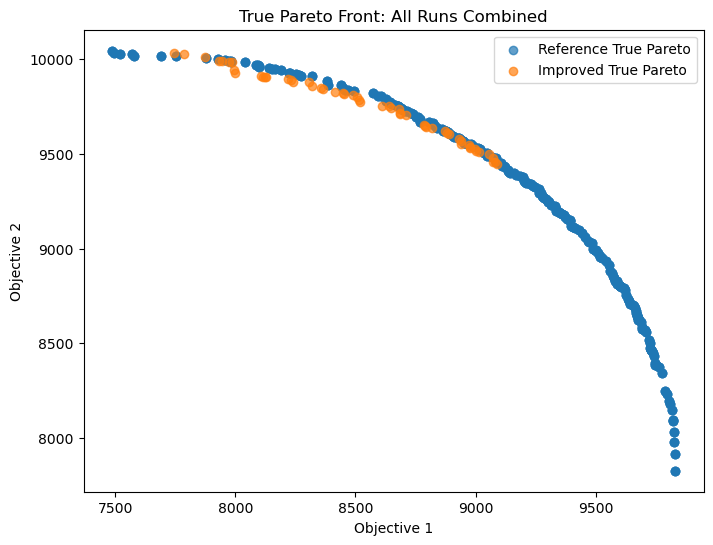

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("bro6.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()